Code copied from: https://www.kaggle.com/alexryzhkov/n3-tps-april-21-lightautoml-starter

In [1]:
%matplotlib inline

# Standard python libraries
import os
import time
import re

# Installed libraries
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# Imports from our package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
# from lightautoml.utils.profiler import Profiler # Deprecated

# Parameters

In [30]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 8*3600 # Time in seconds for automl run

In [31]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Read data

In [37]:
train_data = pd.read_csv('../Data/train_w_nan.csv', index_col = 0)
train_data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f111,f112,f113,f114,f115,f116,f117,f118,claim,count_na
id,,,,,,,,,,,,,,,,,,,,,
0,0.10859,0.004314,-37.566,0.017364,0.28915,-10.25100,135.12,168900.0,3.992400e+14,86.489,...,1.7482,1.90960,-7.11570,4378.80,1.2096,8.613400e+14,140.100000,1.01770,1,1
1,0.10090,0.299610,11822.000,0.276500,0.45970,-0.83733,1721.90,119810.0,3.874100e+15,9953.600,...,4.1684,0.34808,4.14200,913.23,1.2464,7.575100e+15,1861.000000,0.28359,0,0
2,0.17803,-0.006980,907.270,0.272140,0.45948,0.17327,2298.00,360650.0,1.224500e+13,15827.000,...,1.2042,0.26290,8.13120,45119.00,1.1764,3.218100e+14,3838.200000,0.40690,1,5
3,0.15236,0.007259,780.100,0.025179,0.51947,7.49140,112.51,259490.0,7.781400e+13,-36.837,...,2.0694,0.79631,-16.33600,4952.40,1.1784,4.533000e+12,4889.100000,0.51486,1,2
4,0.11623,0.502900,-109.150,0.297910,0.34490,-0.40932,2538.90,65332.0,1.907200e+15,144.120,...,1.5298,1.14640,-0.43124,3856.50,1.4830,-8.991300e+12,3959.204669,0.23049,1,8


In [38]:
test_data = pd.read_csv('../Data/test_w_nan.csv', index_col = 0)
test_data.head()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,...,f110,f111,f112,f113,f114,f115,f116,f117,f118,count_na
id,,,,,,,,,,,,,,,,,,,,,
957919,0.165850,0.487050,1295.00,0.02310,0.31900,0.90188,573.29,3743.7,2.705700e+12,6221.000,...,-22.1890,2.0655,0.430880,-10.7410,81606.0,1.1940,1.980400e+14,2017.1,0.46357,1
957920,0.129650,0.373480,1763.00,0.72884,0.33247,-1.26310,875.55,554370.0,5.955700e+14,934.430,...,-1.6342,1.5736,-1.071200,11.8320,90114.0,1.1507,4.388000e+16,6638.9,0.28125,0
957921,0.120190,0.445210,736.26,0.04615,0.29605,0.31665,2659.50,317140.0,3.977800e+14,131.810,...,-32.7800,2.1364,-1.931200,-3.2804,37739.0,1.1548,1.718100e+14,5844.0,0.13797,1
957922,0.054008,0.395960,996.14,0.85934,0.36678,-0.17060,386.56,325680.0,-3.432200e+13,-26.473,...,-2.4162,1.5199,-0.011633,1.3840,26849.0,1.1490,2.138800e+17,6173.3,0.32910,0
957923,0.079947,-0.006919,10574.00,0.34845,0.45008,-1.84200,3027.00,428150.0,9.291500e+11,5999.400,...,-18.6300,3.7387,0.757080,-4.9405,50336.0,1.2488,2.151300e+17,2250.1,0.33796,0


In [39]:
submission = pd.read_csv('../Data/sample_solution.csv', index_col = 0)
submission.head()

,claim
id,
957919,0.5
957920,0.5
957921,0.5
957922,0.5
957923,0.5


# Train model

In [40]:
%%time

task = Task('binary', loss = 'logloss', metric = roc_auc_score)

Wall time: 3 ms


In [41]:
%%time 

roles = {'target' : 'claim'}

automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'random_state': RANDOM_STATE}, # 'cv': N_FOLDS, 
                       general_params={'use_algos': [['lgb', 'lgb_tuned', 'cb', 'cb_tuned']]}
                      )

oof_pred = automl.fit_predict(train_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

# Fast feature importances calculation
importances = automl.get_feature_scores('fast')

Start automl preset with listed constraints:
- time: 28800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (957919, 120)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 28768.941902160645 secs
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.509904	valid's Opt metric: 0.810416
[200]	valid's binary_logloss: 0.509196	valid's Opt metric: 0.811915
[300]	valid's binary_logloss: 0.509489	valid's Opt metric: 0.811735
Early stopping, best iteration is:
[203]	valid's binary_logloss: 0.509193	valid's Opt metric: 0.811914
Selector_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...

===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LightGBM =====

Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.510403	valid's Op

In [42]:
test_pred = automl.predict(test_data)
print('Prediction for te_data:\n{}\nShape = {}'.format(test_pred, test_pred.shape))

submission['claim'] = test_pred.data[:, 0]

Prediction for te_data:
array([[0.58750516],
       [0.11969324],
       [0.61386937],
       ...,
       [0.7540916 ],
       [0.134525  ],
       [0.74502075]], dtype=float32)
Shape = (493474, 1)


In [43]:
submission

,claim
id,
957919,0.587505
957920,0.119693
957921,0.613869
957922,0.132171
957923,0.146169
...,...
1451388,0.826813
1451389,0.113129
1451390,0.754092


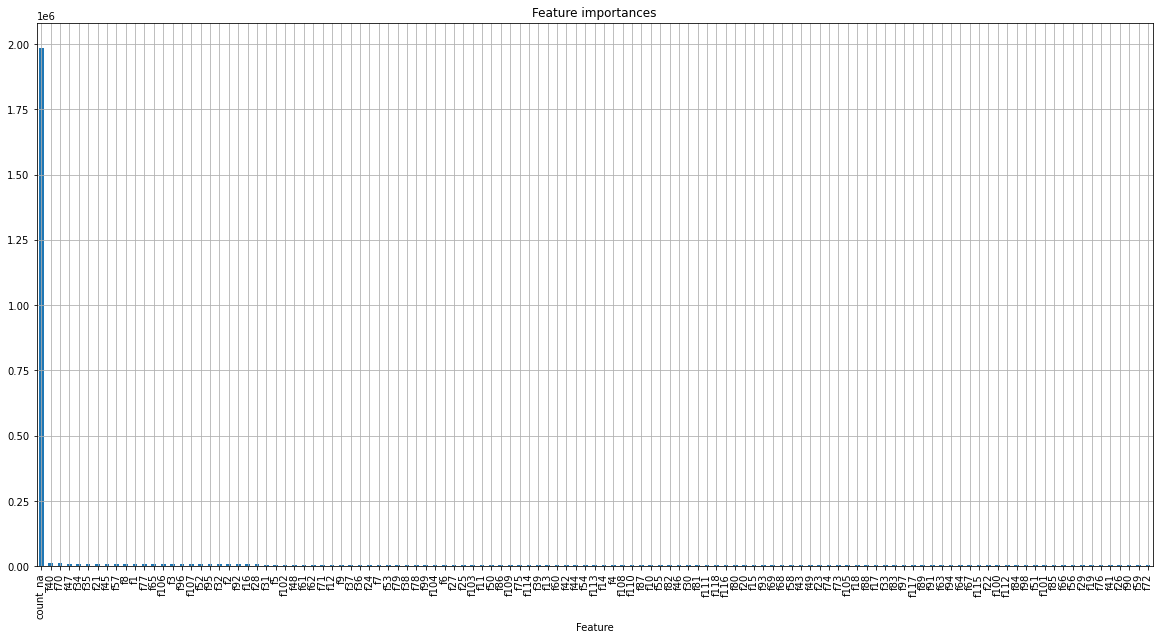

In [44]:
plt.figure(figsize = (20, 10))
importances.set_index('Feature')['Importance'].plot.bar()
plt.title('Feature importances')
plt.grid(True)
plt.show()

In [46]:
submission.to_csv('../Submissions/lightautoml_w_nan.csv', index = True)